In [1]:
import numpy as np
import cv2 as cv
import glob
import pickle
import numpy as np
import os
import pyvista as pv
import pandas as pd
import matplotlib.pyplot as plt
import open3d as o3d
from pyntcloud import PyntCloud
from scipy.spatial.transform import Rotation

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\pyntcloud\utils\numba.py:4: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\pyntcloud\utils\numba.py:11: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\pyntcloud\utils\numba.py:18: NumbaDep

# Camera Calibration

In [2]:
def find_corners(images, chessboardSize):
    '''Finds where in the images the chessboard corners are.'''
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)
    for image in images:
        img = cv.imread(image)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    cv.destroyAllWindows()
    return objpoints, imgpoints

def camera_matrix_error(objpoints, imgpoints, rvecs, tvecs, cameraMatrix, dist):
    '''Uses the points found with find_corners and the results from cv.calibrateCamera to project the chessboard and compare with the original to find the error in pixels'''
    total_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, dist)
        total_error += cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)
    mean_error = total_error/len(objpoints)
    return(mean_error)


def nested_change(item, func):
    if isinstance(item, list):
        return [nested_change(x, func) for x in item]
    return func(item)


def get_colmap_camera_matrix(folder, camera_type=None):
    '''Function still in progress
    
    Grabs colmap camera matrix from file.
    Camera types: SIMPEL_RADIAL, PINHOLE, SIMPLE_PINHOLE
    See https://colmap.github.io/cameras.html for further info.'''
    with open(folder + "/cameras.txt") as f:
        lines = f.readlines()
    if camera_type is not None:
        filtered_lines = [line for line in lines if camera_type in line]
    else:
        for i, line in enumerate(lines):
            if "Number of cameras:" in line:
                num_cameras_line_index = i
                break
        filtered_lines = lines[num_cameras_line_index+1:]
    if filtered_lines == []:
        print(f"No camera matrix found for {camera_type} type in file.")
    else:
        matrices = []
        for line in filtered_lines:
            line = line.split()
            camera_name = line[1]
            # Create camera matrices for all found cameras. Corrections based on different value outputs
            camera_matrix = [[line[4], 0, line[6 if line[1]=="PINHOLE" else 5]], [0, line[4], line[7 if line[1]=="PINHOLE" else 6]], [0, 0, 1]]
            camera_matrix = nested_change(camera_matrix, float)
            matrices.append([camera_name, np.array(camera_matrix)])
    return matrices
    


In [3]:
folder = "colmap reconstruction/space carving example"
camera_type = None

colmap_camera_matrices = get_colmap_camera_matrix(folder, None)
colmap_camera_matrices

Camera_matrix = colmap_camera_matrices[0][1]
Camera_matrix

array([[2.91232135e+03, 0.00000000e+00, 3.60000000e+02],
       [0.00000000e+00, 2.91232135e+03, 2.88000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [26]:
calibration_images = glob.glob('camera calibration/*.jpg')

objpoints, imgpoints = find_corners(calibration_images, chessboardSize)

# Construct camera matrix from found corners.
ret, cameraMatrix, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, frameSize, None, None)

# get camera matrix found by colmap
# colmap_camera_matrix = get_colmap_camera_matrix("colmap reconstruction/volume calibration")

# Save the camera calibration result
pickle.dump((cameraMatrix, dist), open( "calibration.pkl", "wb" ))
pickle.dump(cameraMatrix, open( "cameraMatrix.pkl", "wb" ))
pickle.dump(dist, open( "dist.pkl", "wb" ))

In [27]:
cameraMatrix

array([[5.63285434e+03, 0.00000000e+00, 2.10569685e+03],
       [0.00000000e+00, 9.78888518e+03, 1.75027282e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [28]:
print( "total error: {}".format(camera_matrix_error(objpoints, imgpoints, rvecs, tvecs, cameraMatrix, dist)) )

total error: 12.010805370078959


# Volume Calibration

## Estimate R and t

In [4]:
def get_colmap_camera_pose(folder, file_type):
    '''Uses images.txt created by colmap to find the camera poses.
    path: path to folder, not file'''
    with open(folder +"/images.txt") as f:
        lines = f.readlines()
    filtered_lines = [line for line in lines if file_type in line]
    numpy_array = []
    for line in filtered_lines:
        values_except_name = line.split()[: -1]

        try:
            floats = list(map(float, values_except_name))
            numpy_array.append(floats)
        except ValueError as e:
            print(f"Error converting value to float: {e}")
    numpy_array = np.array(numpy_array)

    camera_poses = []
    for data in numpy_array:
        quat = data[1:5]
        R = Rotation.from_quat(quat).as_matrix()
        t = data[5:-1]
        pose = np.hstack((R,t.reshape(-1,1)))
        camera_poses.append(pose)
    return camera_poses

camera_poses_calibration = get_colmap_camera_pose("colmap reconstruction/space carving example", "ppm")

In [5]:
def plot_camera_poses(camera_poses):
    '''Plots found camera poses.
    Can be used to check if poses are correct'''
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract R and t from each camera pose
    for pose in camera_poses:
        R = pose[:, :3]  # Rotation matrix
        t = pose[:, 3]   # Translation vector

        # Camera coordinate system axes
        x_axis = R[0, :]
        y_axis = R[1, :]
        z_axis = R[2, :]

        # Camera position
        camera_position = -R.T @ t

        # Plot camera coordinate system
        ax.quiver(camera_position[0], camera_position[1], camera_position[2],
                  x_axis[0], x_axis[1], x_axis[2], color='r', length=0.2, arrow_length_ratio=0.1)
        ax.quiver(camera_position[0], camera_position[1], camera_position[2],
                  y_axis[0], y_axis[1], y_axis[2], color='g', length=0.2, arrow_length_ratio=0.1)
        ax.quiver(camera_position[0], camera_position[1], camera_position[2],
                  z_axis[0], z_axis[1], z_axis[2], color='b', length=0.2, arrow_length_ratio=0.1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Camera Poses')
    plt.show()

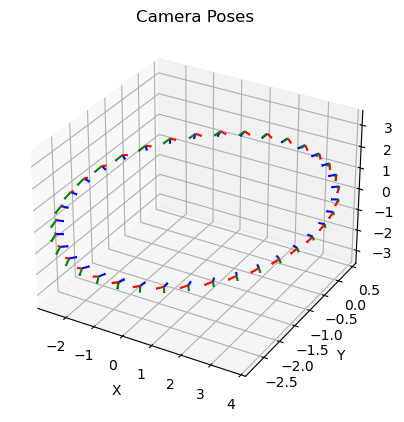

In [6]:
plot_camera_poses(camera_poses_calibration)

In [7]:
P_calibration = Camera_matrix@camera_poses_calibration

In [ ]:
#######
'''Note:
This code works, and can find camera poses. 
But the camera poses are an arbitrary scale and don't use the same reference point.
Hence, these poses are incorrect and should not be used.
Code is kept as it can teach about keypoint matching
'''

# # Input directory containing images
# input_dir = "volume calibration"

# # Get a list of all image file paths in the directory
# image_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".jpg")]

# # Camera calibration matrix
# K = cameraMatrix
# # Feature detector and descriptor
# detector = cv.SIFT_create()

# # Create FLANN-based matcher
# index_params = dict(algorithm=0, trees=5)  # Dummy value for 'algorithm'
# search_params = dict(checks=50)
# matcher = cv.FlannBasedMatcher(index_params, search_params)

# # Find feature matches between image pairs
# def match_images(img1, img2):
#     kp1, des1 = detector.detectAndCompute(img1, None)
#     kp2, des2 = detector.detectAndCompute(img2, None)
#     matches = matcher.knnMatch(des1, des2, k=2)
#     # Apply ratio test to filter good matches
#     good_matches = []
#     for m, n in matches:
#         if m.distance < 0.7 * n.distance:
#             good_matches.append(m)
#     return kp1, kp2, good_matches

# # Estimate camera poses from feature matches
# def estimate_pose(kp1, kp2, matches):
#     points1 = np.array([kp1[m.queryIdx].pt for m in matches])
#     points2 = np.array([kp2[m.trainIdx].pt for m in matches])
#     E, mask = cv.findEssentialMat(points1, points2, K)
#     _, R, t, mask = cv.recoverPose(E, points1, points2, K)
#     return R, t


# # Resize image while maintaining aspect ratio
# def resize_image(img, max_dim):
#     height, width = img.shape[:2]
#     if height > width:
#         new_height = max_dim
#         new_width = int(width * (max_dim / height))
#     else:
#         new_width = max_dim
#         new_height = int(height * (max_dim / width))
#     resized_img = cv.resize(img, (new_width, new_height))
#     return resized_img

# # Perform SFM pipeline
# image_points = []
# camera_poses_calibration = []
# for i in range(len(image_paths)):
#     # Load image
#     img = cv.imread(image_paths[i])
    
#     # Resize image to reduce processing time
#     max_dim = 1400
#     resized_img = resize_image(img, max_dim)

#     # Extract features and match with previous image
#     if i == 0:
#         image_points.append(None)
#         camera_poses_calibration.append(np.eye(3, 4))
#     else:
#         kp1, kp2, matches = match_images(prev_img, resized_img)
#         R, t = estimate_pose(kp1, kp2, matches)
#         camera_poses_calibration.append(np.hstack((R, t)))
    
#     # Store current image for the next iteration
#     prev_img = resized_img

# P_calibration = K@camera_poses_calibration

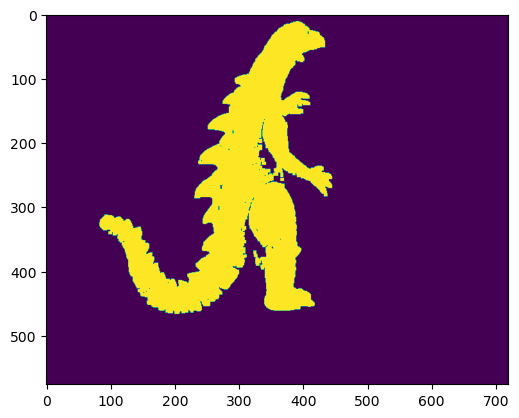

In [8]:
def read_images(files):
    '''Reads the images with opencv and sets them in RGB format.'''
    images = []
    for f in files:
        im = cv.imread(f, cv.IMREAD_UNCHANGED).astype(float)
        im /= 255
        images.append(im[:, :, ::-1])
    return images

def silhouette(image, background, threshold):
    '''Creates a silhouette by subtracting a set of rgb values from each pixel.
    It sets all pixels below the threshold to 0 and above to 1.'''
    im = image.copy()
    temp = np.abs(im-background)
    temp = np.sum(temp, axis=2)

    y, x = np.where(temp <= threshold)
    im[y, x, :] = [0.0, 0.0, 0.0]
    im = im[:, :, 0]

    im[im>0] = 1.0

    kernel = np.ones((5, 5), np.uint8)
    im = cv.morphologyEx(im, cv.MORPH_OPEN, kernel)
    return im

def get_background_colour(image):
    '''Grabs the rgb values of the most dominant colour in the image.
    This can be used to background filter if the image background is uniform in colour'''
    pixels=np.float32(image.reshape(-1,3))
    n_colors = 2 # colour groups
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    dominant = palette[np.argmax(counts)]
    return dominant


images = read_images(glob.glob("data/*.ppm"))
background = [0.0, 0.0, 0.75] # most common RGB value of background, divided by 255
# background = get_background_colour(images[0]) # get most dominant colour in image
threshold = 1.1 #adjust to make image visible

silhouettes_calibration = []
for image in images:
    silhouettes_calibration.append(silhouette(image, background, threshold))
plt.imshow(silhouettes_calibration[0])

In [9]:
def voxel_grid(size, offset1, offset2):
    x, y, z = np.mgrid[:size, :size, :size]
    pts = np.vstack((x.flatten(), y.flatten(), z.flatten())).astype(float)
    pts = pts.T
    nb_points_init = pts.shape[0]
    xmax, ymax, zmax = np.max(pts, axis=0)
    pts[:, 0] /= xmax
    pts[:, 1] /= ymax
    pts[:, 2] /= zmax
    center = pts.mean(axis=0)
    pts -= center
    # pts /= -1
    
    # Extra offset, trial and error
    pts /= offset1
    pts[:, 2] += offset2
    
    pts = np.vstack((pts.T, np.ones((1, nb_points_init))))
    return pts

pts = voxel_grid(120, 5, -0.62)

In [10]:
def fill_grid(pts, projection, silhouette):
    imgW, imgH = silhouette.shape
    uvs = projection @ pts
    uvs /= uvs[2, :] #normalize data
    uvs = np.round(uvs).astype(int)
    x_good = np.logical_and(uvs[0, :] >= 0, uvs[0, :] < imgH)
    y_good = np.logical_and(uvs[1, :] >= 0, uvs[1, :] < imgW)
    good = np.logical_and(x_good, y_good)
    indices = np.where(good)[0]
    fill = np.zeros(uvs.shape[1])
    sub_uvs = uvs[:2, indices]
    res = im[sub_uvs[1, :], sub_uvs[0, :]]
    fill[indices] = res
    return fill, res

filled_calibration = []
for projection, im in zip(P_calibration, silhouettes_calibration):
    fill, res = fill_grid(pts, projection, im)
    filled_calibration.append(fill)
filled_calibration = np.vstack(filled_calibration)
print(np.sum(filled_calibration, axis=0).max())

0.0


In [11]:
def get_volume(pts, filled_grid, threshold, visualize):
    occupancy = np.sum(filled_grid, axis=0)
    pts = pts.T
    out_points = pts[occupancy > threshold, :]
    with open("object.obj", "w") as file:
        for p in out_points:
            file.write("v " + " ".join(map(str, p)) + "\n")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(out_points[:,:3])
    o3d.io.write_point_cloud("./pointcloud.ply", pcd)
    if visualize:
        o3d.visualization.draw_geometries([pcd])
    
    point_cloud = PyntCloud.from_file("pointcloud.ply")
    convex_hull_id = point_cloud.add_structure("convex_hull")
    convex_hull = point_cloud.structures[convex_hull_id]

    volume = convex_hull.volume
    return volume

straal_bal = 0.067/2
volume_bal = 3.14*(4/3)*straal_bal**3
print(volume_bal)
calibration_volume = volume_bal # in mm2, cm2, m2. user defined
volume = get_volume(pts, filled_calibration, 24, True)
ratio = calibration_volume/volume

# Actual volume

In [ ]:
with open("colmap reconstruction/test item 2/images.txt") as f:
    lines = f.readlines()

filtered_lines = [line for line in lines if "jpg" in line]

numpy_array = []
for line in filtered_lines:
    values_except_name = line.split()[:-1]

    try:
        float_values = list(map(float, values_except_name))
        numpy_array.append(float_values)
    except ValueError as e:
        print(f"Error converting values to floats: {e}")
numpy_array = np.array(numpy_array)

camera_poses = []
for data in numpy_array:
    quat = data[1:5]
    R = Rotation.from_quat(quat).as_matrix()
    t = data[5:-1]
    pose = np.hstack((R,t.reshape(-1,1)))
    camera_poses.append(pose)

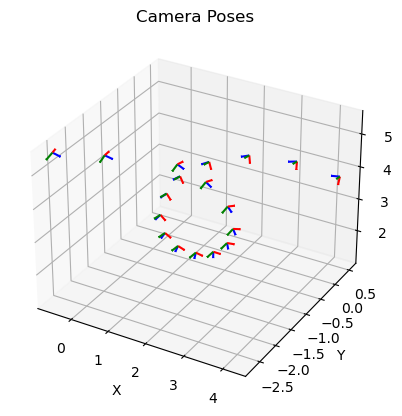

In [ ]:
plot_camera_poses(camera_poses)

In [ ]:
# Input directory containing images
input_dir = "images/set 2"

# Get a list of all image file paths in the directory
image_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".jpg")]

# Camera calibration matrix
K = cameraMatrix
# Feature detector and descriptor
detector = cv.SIFT_create()

# Create FLANN-based matcher
index_params = dict(algorithm=0, trees=5)  # Dummy value for 'algorithm'
search_params = dict(checks=50)
matcher = cv.FlannBasedMatcher(index_params, search_params)

# Perform SFM pipeline
image_points = []
camera_poses = []
for i in range(len(image_paths)):
    # Load image
    img = cv.imread(image_paths[i])
    
    # Resize image to reduce processing time
    max_dim = 1400
    resized_img = resize_image(img, max_dim)

    # Extract features and match with previous image
    if i == 0:
        image_points.append(None)
        camera_poses.append(np.eye(3, 4))
    else:
        kp1, kp2, matches = match_images(prev_img, resized_img)
        R, t = estimate_pose(kp1, kp2, matches)
        camera_poses.append(np.hstack((R, t)))
    
    # Store current image for the next iteration
    prev_img = resized_img

P = K@camera_poses

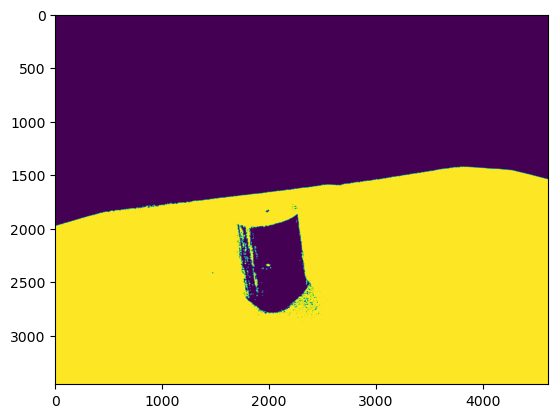

In [ ]:
images = read_volume_images(glob.glob("images/set 2/*.jpg"))
background = [117/255, 72/255, 131/255] # most common RGB value of background
threshold = 0.6 #adjust to make image visible

silhouettes = []
for image in images:
    silhouettes.append(silhouette(image, background, threshold))
plt.imshow(silhouettes[0])

In [ ]:
pts = voxel_grid(120, 1, 0)

In [ ]:
filled = []
for projection, im in zip(P, silhouettes):
    fill = fill_grid(pts, projection, im)
    filled.append(fill)
filled = np.vstack(filled)
print(np.sum(filled, axis=0).max()) # indicated for volume threshold

16.0


In [ ]:
volume = get_volume(pts, filled, 5, False)
actual_volume = ratio*volume
print(actual_volume)

0.014091258154267565


In [ ]:
straal_bal = 0.067/2
volume_bal = 3.14*(4/3)*straal_bal**3
print(volume_bal)

0.00015739930333333335


In [ ]:
print(straal_bal)

0.0335


In [ ]:
diameter_cilinder = 0.036
hoogte = 0.044
volume = (diameter_cilinder/2)**2*3.14*hoogte
print(volume)

4.4763839999999996e-05
